<a href="https://colab.research.google.com/github/JxxnDx/Notebooks/blob/main/1_VanillaRNN_1_NumericSequencePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Numeric Sequence Prediction with a *Vanilla* RNN (PyTorch)

**Goal:** How to build, train and evaluate a simple recurrent neural network (RNN) to predict the next value in a numeric sequence (sine wave).

**Steps:**
- How to prepare sequential data for an RNN
- How to build a vanilla RNN with `nn.RNN`
- Training and validation loops (including gradient clipping)
- Visualizing results and making predictions

In [ ]:

## 1. Imports and setup
import math, random, time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

## Reproducibility by making number generation consistent across runs: data generation, model creation, and training
SEED = 42
random.seed(SEED) #Python's built-in random module
np.random.seed(SEED) #NumPy random operations
torch.manual_seed(SEED) #PyTorch random operations (weight init, shuffling)

## Device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


## Data generation (sine wave)

We will use a sine wave as a continuous signal that RNNs can learn to predict.
Given a sliding window of `seq_length` consecutive values, the task is to predict the **next** value.
This is a simple regression task that highlights sequence modelling.

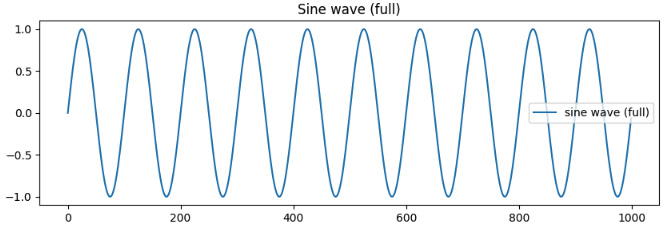

In [ ]:
## 2. Generate sine wave data and prepare sequences

def create_sine_data(num_points=1000, freq=0.02):
    x = np.arange(num_points)
    y = np.sin(2 * math.pi * freq * x)
    return y.astype(np.float32)

def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    ys = np.array(ys)
    return np.array(xs), ys

# hyperparameters for data
num_points = 1000
seq_length = 100

data = create_sine_data(num_points=num_points, freq=0.02)
X, y = create_sequences(data, seq_length=seq_length)

print('Full data shape:', data.shape)
print('X shape (num_samples, seq_length):', X.shape)
print('y shape (num_samples,):', y.shape)

Full data shape: (1000,)
X shape (num_samples, seq_length): (900, 100)
y shape (num_samples,): (900,)


In [ ]:
## 3. Convert to PyTorch tensors and create DataLoaders

# reshape X to (samples, seq_length, features). Here features=1 (univariate time series)
X_tensor = torch.tensor(X).unsqueeze(-1)   # shape: (N, seq_length, 1)
y_tensor = torch.tensor(y).unsqueeze(-1)   # shape: (N, 1)

dataset = TensorDataset(X_tensor, y_tensor)

# train / validation split (80 / 20) - Can be changed to evaluate different Splits
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

print(f'Train samples: {len(train_ds)}, Val samples: {len(val_ds)}')
print('Example batch X shape:', next(iter(train_loader))[0].shape)

Train samples: 720, Val samples: 180
Example batch X shape: torch.Size([64, 100, 1])


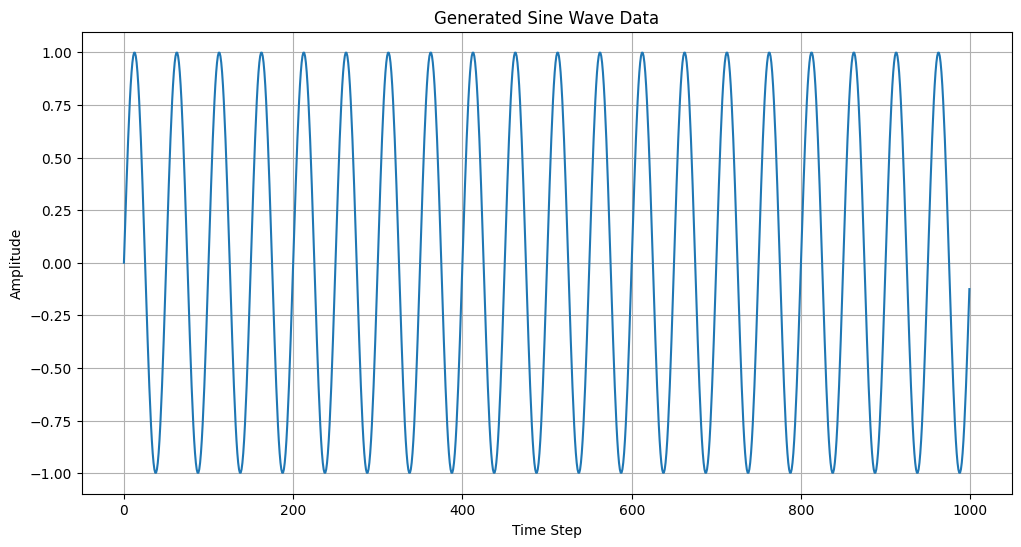

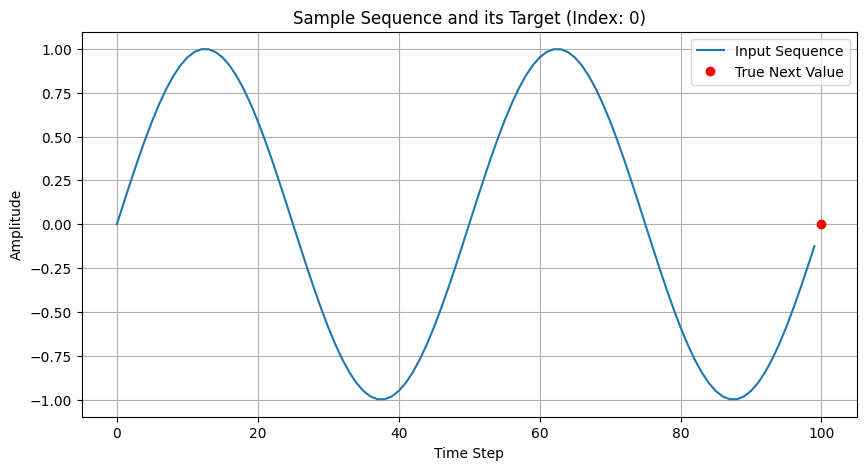

In [ ]:

# Visualization of the sine wave
plt.figure(figsize=(12, 6))
plt.plot(data)
plt.title('Generated Sine Wave Data')
plt.xlabel('Time Step')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# show one sequence window and the target
plt.figure(figsize=(10, 5))
index = 0  # You can change this index to view different sequences
sample_x = X[index]
sample_y = y[index]

plt.plot(range(seq_length), sample_x, label='Input Sequence')
plt.plot(seq_length, sample_y, 'ro', label='True Next Value')
plt.title(f'Sample Sequence and its Target (Index: {index})')
plt.xlabel('Time Step')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

## Model: Vanilla RNN (PyTorch)

We will use a simple architecture:
- `nn.RNN` for the recurrent layer (vanilla RNN cell)
- A fully-connected (`nn.Linear`) layer to map the last hidden state to the scalar prediction

Important details:
- `batch_first=True` makes input/output shapes `(batch, seq, features)`
- We'll use the output from the **last time step** (`out[:, -1, :]`) to predict the next value

In [ ]:
## 4. Define the vanilla RNN model
class VanillaRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1, output_size=1):
        super(VanillaRNN, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True, nonlinearity='tanh')
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        # x shape: (batch, seq_length, input_size)
        out, hidden = self.rnn(x)            # out shape: (batch, seq_length, hidden_size)
        last = out[:, -1, :]                 # get last time-step output
        out = self.fc(last)                  # map to output_size (here 1)
        return out

# instantiate and move to device
hidden_size = 32
model = VanillaRNN(input_size=1, hidden_size=hidden_size, num_layers=1, output_size=1).to(device)
print(model)

VanillaRNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


## Training loop — explanation

Each epoch we:
1. Set model to `train()` mode.
2. Loop over batches from `train_loader`:
   - Move inputs and targets to device
   - Zero gradients (`optimizer.zero_grad()`)
   - Forward pass `outputs = model(inputs)`
   - Compute loss (MSE for regression)
   - `loss.backward()` to compute gradients (BPTT does the gradient back through time)
   - Gradient clipping to avoid exploding gradients
   - `optimizer.step()` to update weights
3. After training pass, evaluate on validation set (model.eval(), torch.no_grad())
4. Record both training and validation loss for monitoring

In [ ]:
## 5. Training setup and loop
num_epochs = 50 ##TESTING
learning_rate = 0.001

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        # gradient clipping (helpful for RNN stability)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0) ##TESTING
        optimizer.step()

        running_loss += loss.item() * batch_x.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # --- Validation ---
    model.eval()
    val_running = 0.0
    with torch.no_grad():
        for val_x, val_y in val_loader:
            val_x = val_x.to(device)
            val_y = val_y.to(device)
            val_out = model(val_x)
            vloss = criterion(val_out, val_y)
            val_running += vloss.item() * val_x.size(0)
    epoch_val_loss = val_running / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    # Print progress
    print(f"Epoch {epoch}/{num_epochs} | Train Loss: {epoch_train_loss:.6f} | Val Loss: {epoch_val_loss:.6f}")


Epoch 1/50 | Train Loss: 0.457282 | Val Loss: 0.383096
Epoch 2/50 | Train Loss: 0.310804 | Val Loss: 0.217948
Epoch 3/50 | Train Loss: 0.151386 | Val Loss: 0.086806
Epoch 4/50 | Train Loss: 0.077652 | Val Loss: 0.041362
Epoch 5/50 | Train Loss: 0.038432 | Val Loss: 0.021512
Epoch 6/50 | Train Loss: 0.016274 | Val Loss: 0.007916
Epoch 7/50 | Train Loss: 0.005387 | Val Loss: 0.002774
Epoch 8/50 | Train Loss: 0.002907 | Val Loss: 0.002403
Epoch 9/50 | Train Loss: 0.002456 | Val Loss: 0.001709
Epoch 10/50 | Train Loss: 0.001863 | Val Loss: 0.001512
Epoch 11/50 | Train Loss: 0.001556 | Val Loss: 0.001257
Epoch 12/50 | Train Loss: 0.001328 | Val Loss: 0.001124
Epoch 13/50 | Train Loss: 0.001151 | Val Loss: 0.000964
Epoch 14/50 | Train Loss: 0.001044 | Val Loss: 0.000891
Epoch 15/50 | Train Loss: 0.000918 | Val Loss: 0.000811
Epoch 16/50 | Train Loss: 0.000844 | Val Loss: 0.000710
Epoch 17/50 | Train Loss: 0.000752 | Val Loss: 0.000640
Epoch 18/50 | Train Loss: 0.000702 | Val Loss: 0.000614
E

### Training and validation loss curves
Plot the recorded losses to inspect learning and check for overfitting.

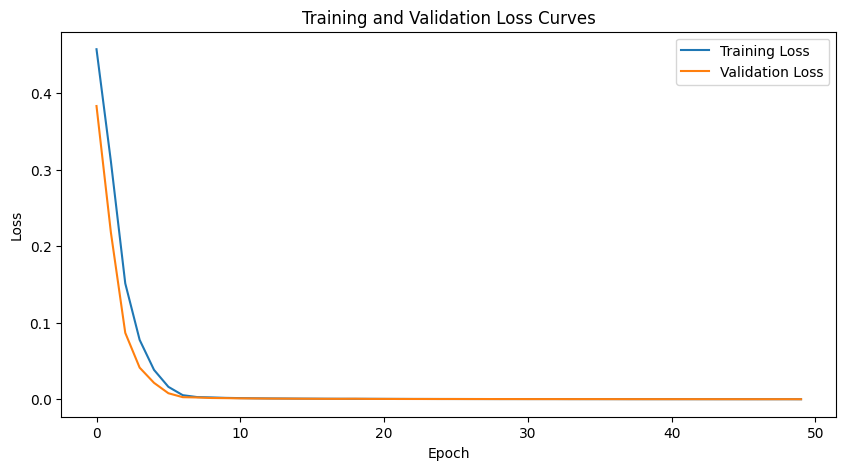

In [ ]:
##INSERT YOUR CODE HERE!
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()


## Evaluation: Predictions and Forecasting

1. Show predicted vs true next value for some validation sequences.
2. Predict **future** values by feeding back predicted values as input to generate multiple steps ahead.


Sample 1: True next value = -0.7705 | Predicted = -0.7906
Sample 2: True next value = -0.0000 | Predicted = -0.0187
Sample 3: True next value = -0.3681 | Predicted = -0.3751
Sample 4: True next value = 0.8443 | Predicted = 0.8588
Sample 5: True next value = -0.8443 | Predicted = -0.8623
Sample 6: True next value = -0.7705 | Predicted = -0.7670
Sample 7: True next value = 0.0000 | Predicted = 0.0112
Sample 8: True next value = -0.6845 | Predicted = -0.7034
Sample 9: True next value = 0.4818 | Predicted = 0.4853
Sample 10: True next value = 0.6845 | Predicted = 0.6997
Input sequence: [1, 0.3681, 0.8763, 0.5358, 0.8443]
Predicted next value: 1.11


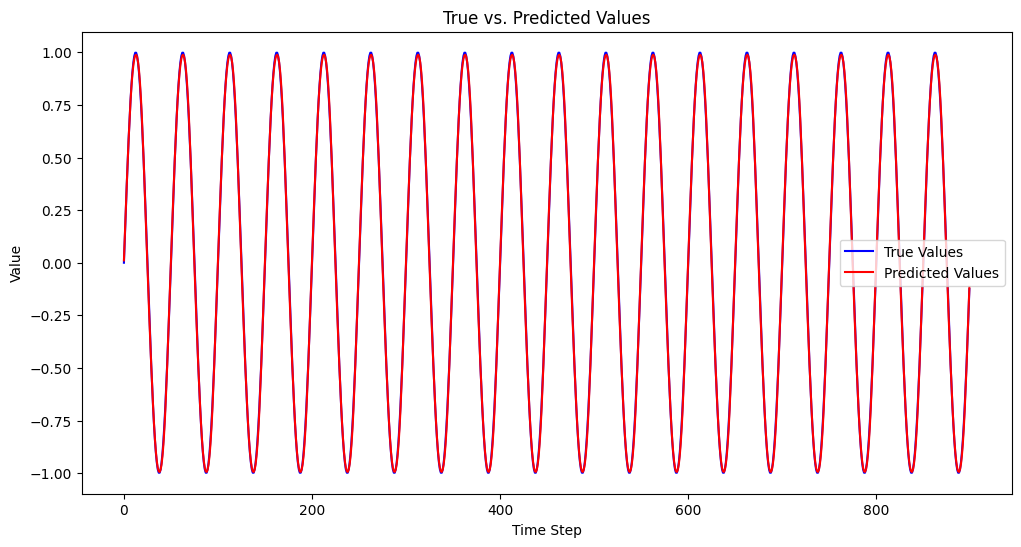

In [ ]:
## 6. Show sample predictions (first 10 val sequences)
model.eval()
samples = 10
with torch.no_grad():
    for i in range(samples):
        seq, true_y = val_ds[i]
        seq = seq.unsqueeze(0).to(device)   # batch size 1
        pred = model(seq).cpu().numpy().ravel()[0]
        print(f'Sample {i+1}: True next value = {true_y.item():.4f} | Predicted = {pred:.4f}')

## 7. FORECASTING
with torch.no_grad():
    sample_input = torch.tensor([[1, 0.3681, 0.8763, 0.5358, 0.8443]], dtype=torch.float32).unsqueeze(-1).to(device) # Move to device
    pred = model(sample_input)
    print(f"Input sequence: [1, 0.3681, 0.8763, 0.5358, 0.8443]")
    print(f"Predicted next value: {pred.item():.2f}")

## 8. PLOT Predictions and ground truth values
# The original 'plt.plot(model(X_tensor).cpu().numpy(), ...)' had the same device issue.
# X_tensor also needs to be moved to the device before being passed to the model for prediction.
# It's good practice to ensure all inputs to the model are on the correct device.
with torch.no_grad():
    # Move X_tensor to the device before passing it to the model
    all_predictions = model(X_tensor.to(device)).cpu().numpy()

plt.figure(figsize=(12, 6))
plt.plot(y, label='True Values', color='blue')
plt.plot(all_predictions, label='Predicted Values', color='red')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('True vs. Predicted Values')
plt.legend()
plt.show()

**EXERCISES**


1. Complete the INSERT YOUR CODE HERE! blocks
2. Describe graphically the sequences (sequence and prediction) of sine wave data. Play with the data hyperparameters.
3. Play with the Vanilla RNN parameters. Sketch the architecture (input, output, layers, neurons). Which change produces a noticeable difference in the results?, Explain.  
4. Increase `hidden_size` to other values, such as 128 and observe results, is there an improvement or overfitting.
5. Try different `seq_length` values (shorter and longer). How this parameter impact on learning?
6. Play with the gradient clipping. What is the effect? How is this helpful in the training?

**SOLUTION**


----


-----


----

----

-----

2. R/  
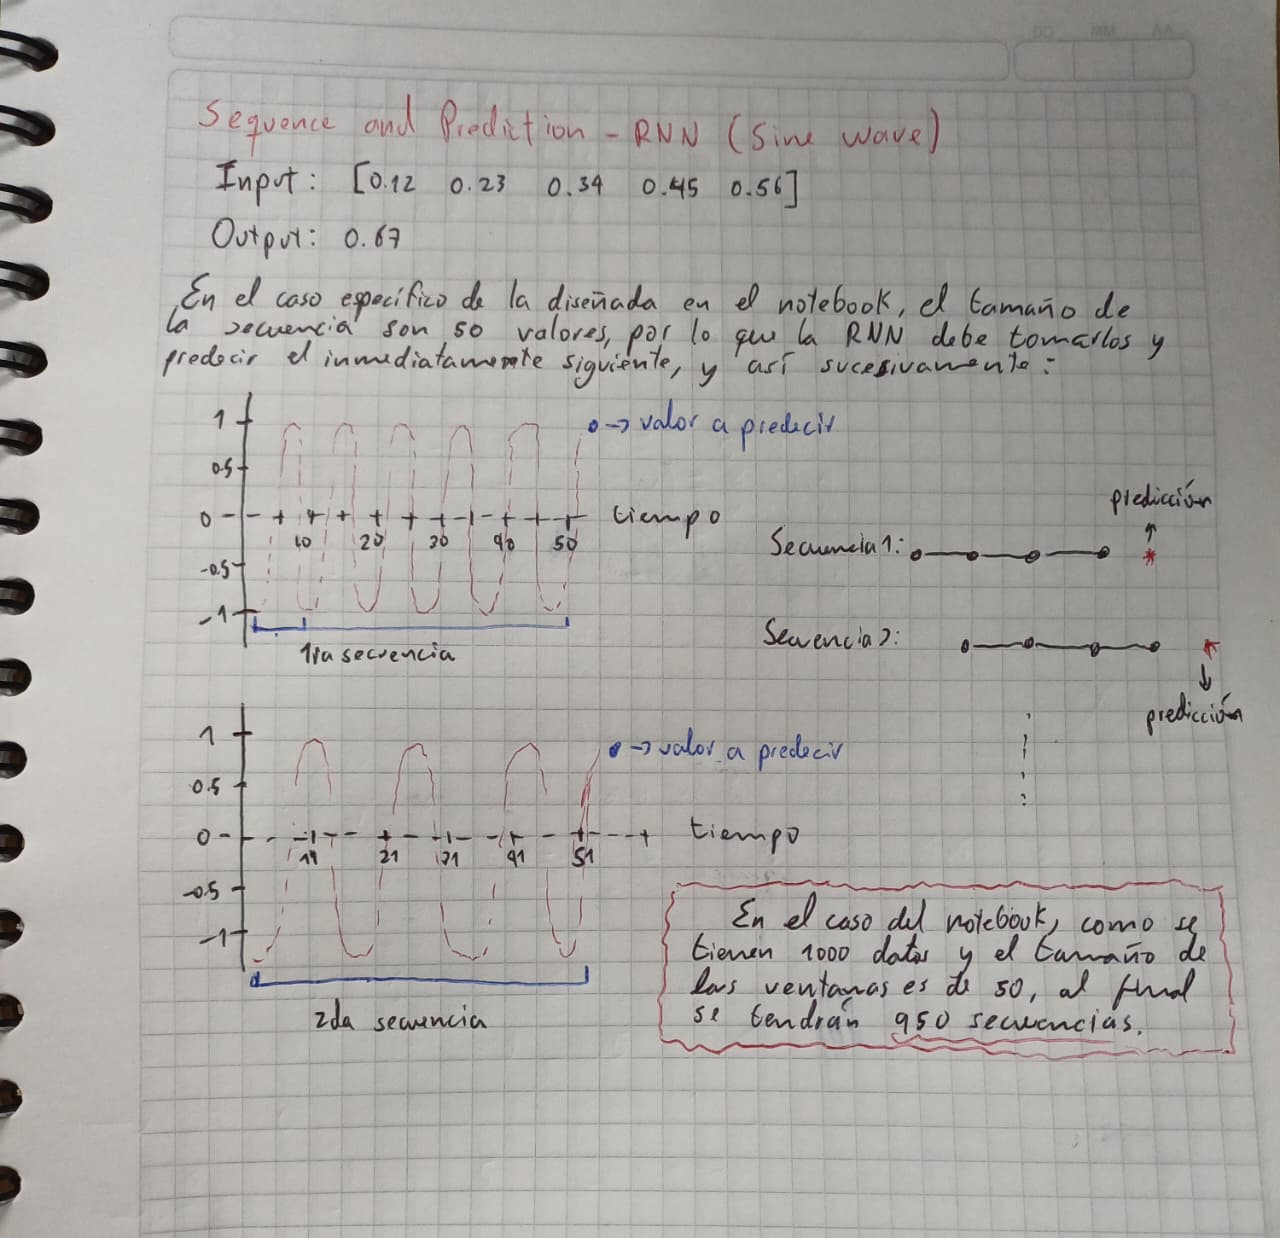

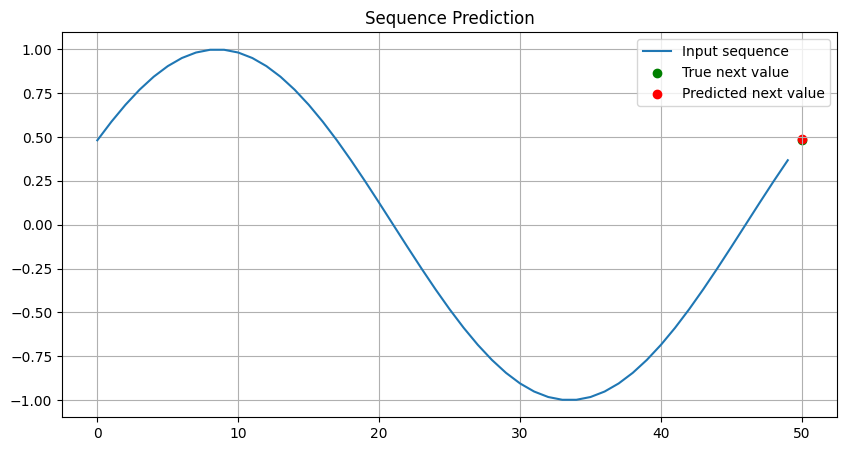

In [ ]:
model.eval()
seq, true_y = val_ds[0]

with torch.no_grad():
    pred = model(seq.unsqueeze(0).to(device))

seq = seq.squeeze().numpy()

plt.figure(figsize=(10,5))
plt.plot(range(len(seq)), seq, label="Input sequence")
plt.scatter(len(seq), true_y.item(), color='green', label="True next value")
plt.scatter(len(seq), pred.item(), color='red', label="Predicted next value")
plt.legend()
plt.title("Sequence Prediction")
plt.grid(True)
plt.show()


3. R/ 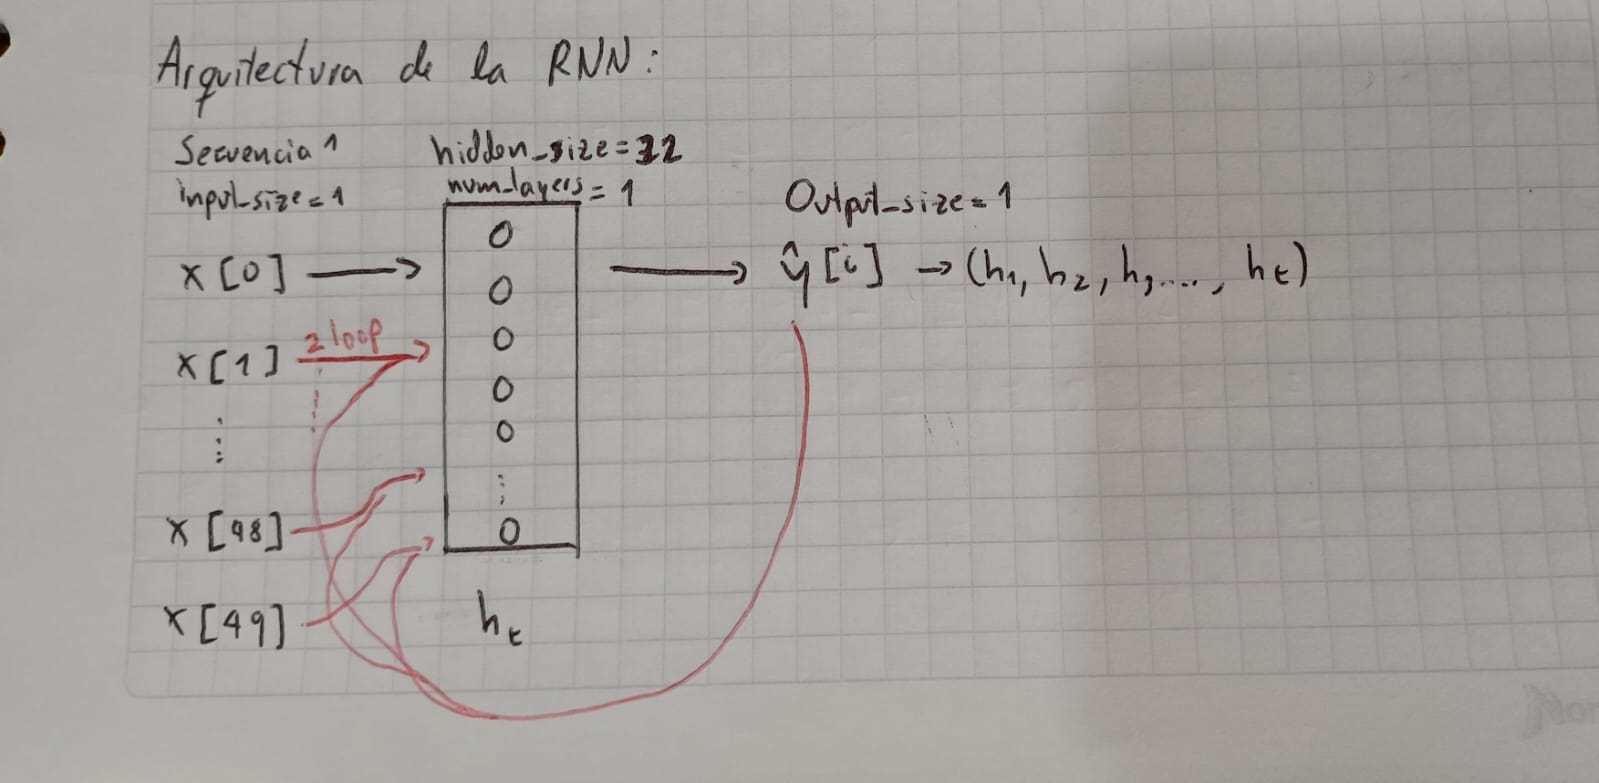

4. R/ Al incrementar el hidden_size, la red presenta una leve mejora, pero a la vez aumenta los riesgos de un posible overfitting, entre mayor sea el número de neuronas mayor se ajustará a los datos por lo que mayor tendencia a overfitting. Sin embargo, en este ejercicio puntual no se evidencia sobreajuste.

5. R/ Al aumentar (o disminuir) el tamaño de la secuencia/ventana tampoco tiene un impacto muy significativo en el entrenamiento o validación, pues las métricas siguen siendo bastante buenas (>0.001). Sin en cambio los leves cambios observados son, al disminuir el tamaño de la secuencia, tarda un poco más en converger a 0 las métricas de error en entrenamiento y validación, y, a su vez, hay un poco más de desfase en la gráfica de valores reales vs predicciones.

6. R/ El gradient clipping es una forma de estabilizar el entrenamiento, lo cual se logra "limitando" el gradiente. Sin clipping, puede ser que se de el caso de exploding gradients teniendo como consecuencia perdidas inestables o que no convergen. En pocas palabras, estabiliza el entrenamiento y evita que hallan actualizaciones de pesos muy grandes que dañen los pesos ya aprendidos. En el caso específico de este ejercicio, se tiene como max_norm = 2, lo que quiere decir que este es límite para el tamaño total del gradiente, o sea que no puede ser mayor que 2, si se da el caso de er mayor, se recorta, pero en su misma dirección.